### Install and import packages

In [ ]:
# Install packages
!pip install bayes_logistic

In [20]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_list = ["Green", "Blue"]
color_map = mcolors.ListedColormap(["Green", "Blue"])

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic
from pypolyagamma import PyPolyaGamma

### Set parameters

In [59]:
# Set parameters
# num_data
num_data = 100
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 1000

# data_x marginal distribution parameters
data_x_marginal_params = [
    [[1.0, 5.0], [(1.0, 0.0), (0.0, 1.0)]],
    [[-5.0, 1.0], [(3.0, 0.0), (0.0, 3.0)]]]

# weights prior distribution parameters
weights_prior_params = [[0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]]]


### Generate data_x

$$
\begin{align*}
  \mathrm{data}\_x &= [c_0\_x, c_1\_x]\\
  c_0\_x &\sim p(x|\mu_0, \sigma_0^2) \\
  c_1\_x &\sim p(x|\mu_1, \sigma_1^2)
\end{align*}
$$


In [60]:
# Generate data_x
data_x_marginal_dists = [
    stats.multivariate_normal(mu, sigma, seed=12345) \
        for mu, sigma in data_x_marginal_params]

c0_x = data_x_marginal_dists[0].rvs(size=(num_data_half))
c1_x = data_x_marginal_dists[1].rvs(size=(num_data_half))
data_x = np.vstack((c0_x, c1_x))

data_x = np.random.randn(num_data, num_feats)
print(data_x.shape)

(100, 2)


#### PolyaGamma Inference function

In [74]:
def pg_inference(X, y, pg_dist, burnin_steps=200):
    #
    num_data, num_feats = X.shape

    # Gibbs sampling with PG augmentation for burnin_steps
    # init states
    beta_mu = np.zeros(num_feats)
    beta_cov = np.diag(np.ones(num_feats))
    beta_hat = np.random.multivariate_normal(beta_mu, beta_cov)
    k = y - 1/2

    # pg = PyPolyaGamma(seed=0)
    # perform Gibbs sampling
    for bid in range(burnin_steps+1):
        # ω ~ PG(b, c) = PG(1, x*β).
        omega_b = np.ones(num_data)
        omega_c = X @ beta_hat
        omega_diag = np.array(
            [pg_dist.pgdraw(b, c) for b, c in zip(omega_b, omega_c)])

        # β ~ N(m, V).
        V = np.linalg.inv(X.T @ np.diag(omega_diag) @ X + np.linalg.inv(beta_cov))
        m = np.dot(V, X.T @ k + np.linalg.inv(beta_cov) @ beta_mu)
        beta_hat = np.random.multivariate_normal(m, V)

    return beta_hat


### Generate prior and posterior samples

In [77]:
### Generate prior and posterior samples
np.random.seed(1)

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)

pg_dist = PyPolyaGamma(seed=0)

samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
for i in range(num_samples):
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    # print(data_x.shape)
    # print(sample_a_y.shape)
    
    # sample weights' posterior from polyagamma inference
    sample_a_weights_posterior = pg_inference(
        data_x, sample_a_y.squeeze(-1), pg_dist, burnin_steps=100)
    samples_a_weights_posterior.append(sample_a_weights_posterior)    

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(1000, 2)


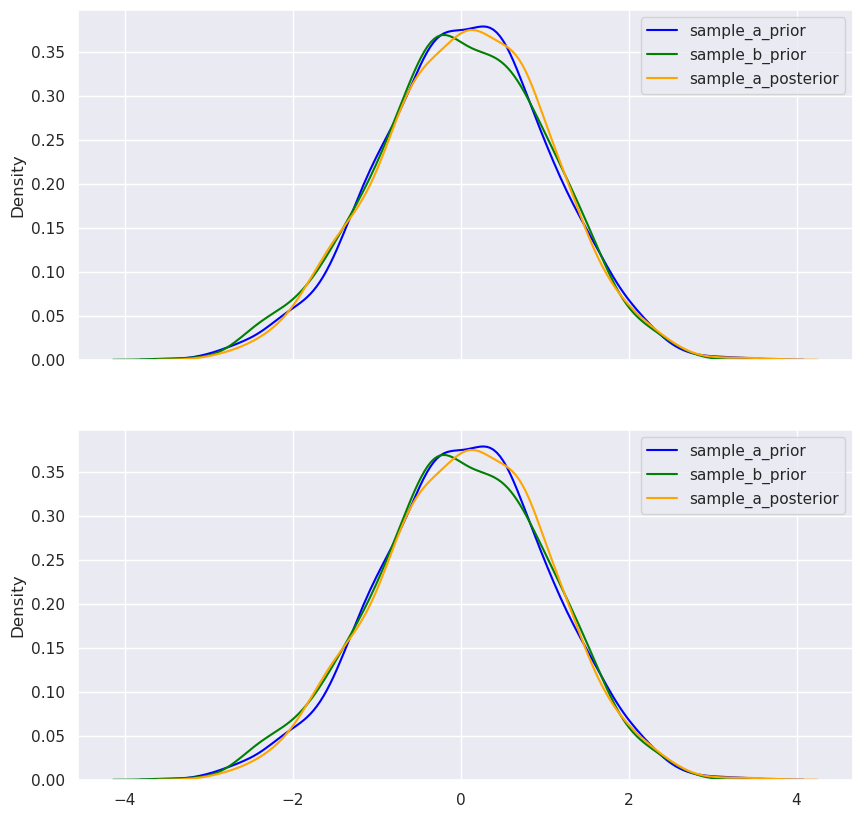

In [78]:
# Visualize the generated prior and posterior samples 
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,0], fill=False, color="blue", label="sample_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,0], fill=False, color="green", label="sample_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,0], fill=False, color="orange", label="sample_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

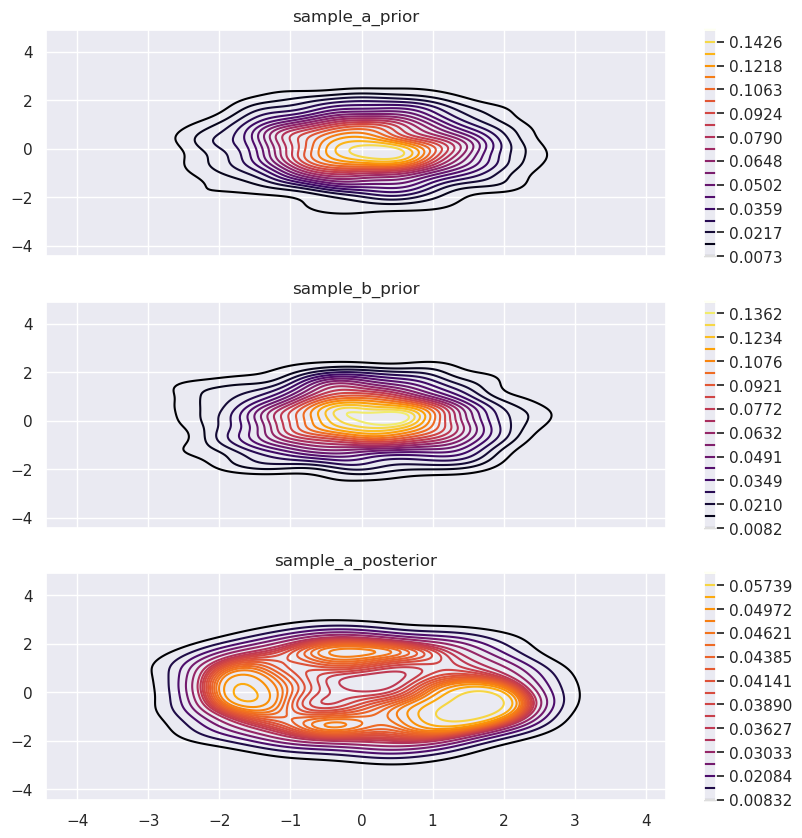

In [70]:
# Visualize the generated prior and posterior samples 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[2])
axes[0].set_title("sample_a_prior")
axes[1].set_title("sample_b_prior")
axes[2].set_title("sample_a_posterior")
plt.show()

#### Comments on the plots
1. In 2d, the posterior samples are quite different from the prior samples 